In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import L0 modules
from l0.layers import L0Linear, L0Conv2d, SparseMLP
from l0.gates import FeatureGate, SampleGate
from l0.penalties import (
    compute_l0_penalty,
    get_sparsity_stats,
    TemperatureScheduler,
    update_temperatures
)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 5. Structured Sparsity with L0

Demonstrating channel-wise structured sparsity for CNNs.

Structured Sparsity Pattern:


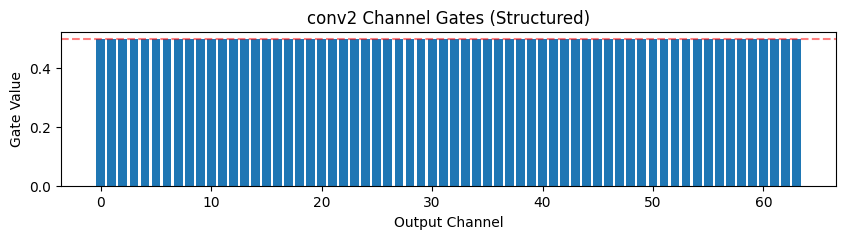


Unstructured Sparsity Pattern:


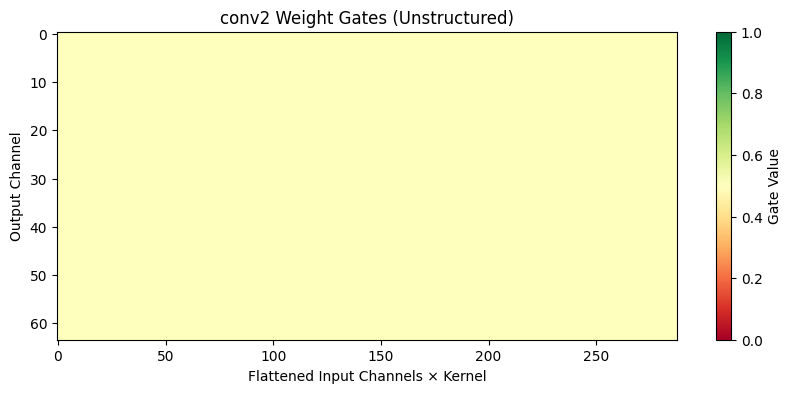

In [3]:
# Visualize structured vs unstructured sparsity patterns
def visualize_conv_sparsity(model, layer_name='conv2'):
    """Visualize sparsity pattern in a conv layer."""
    for name, module in model.named_modules():
        if name == layer_name and isinstance(module, L0Conv2d):
            module.eval()
            with torch.no_grad():
                if model.structured and hasattr(module, 'channel_gates'):
                    # Structured: show channel gates
                    gates = module.channel_gates().cpu().numpy()
                    plt.figure(figsize=(10, 2))
                    plt.bar(range(len(gates)), gates)
                    plt.xlabel('Output Channel')
                    plt.ylabel('Gate Value')
                    plt.title(f'{layer_name} Channel Gates (Structured)')
                    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
                else:
                    # Unstructured: show weight gate heatmap
                    gates = module.weight_gates()
                    # Reshape to (out_channels, -1) for visualization
                    gates_2d = gates.view(gates.shape[0], -1).cpu().numpy()
                    
                    plt.figure(figsize=(10, 4))
                    plt.imshow(gates_2d, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
                    plt.colorbar(label='Gate Value')
                    plt.xlabel('Flattened Input Channels × Kernel')
                    plt.ylabel('Output Channel')
                    plt.title(f'{layer_name} Weight Gates (Unstructured)')
                plt.show()
                break

print("Structured Sparsity Pattern:")
visualize_conv_sparsity(structured_cnn, 'conv2')

print("\nUnstructured Sparsity Pattern:")
visualize_conv_sparsity(unstructured_cnn, 'conv2')

## 6. Temperature Annealing Effects

Demonstrating the importance of temperature scheduling.

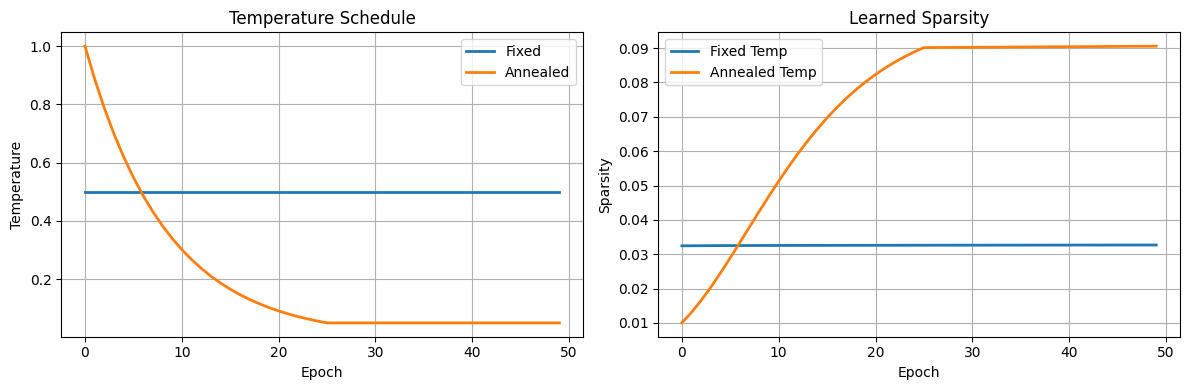

Final sparsity - Fixed: 3.27%, Annealed: 9.06%


In [4]:
# Compare fixed vs annealed temperature
def train_with_temperature_strategy(strategy='fixed', n_epochs=50):
    model = SparseMLP(input_dim=100, hidden_dim=50, output_dim=10, 
                      init_sparsity=0.1, temperature=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    if strategy == 'annealed':
        temp_scheduler = TemperatureScheduler(1.0, 0.05, n_epochs//2)
    
    X = torch.randn(200, 100).to(device)
    y = torch.randint(0, 10, (200,)).to(device)
    
    temps = []
    sparsities = []
    
    for epoch in range(n_epochs):
        if strategy == 'annealed':
            temp = temp_scheduler.get_temperature(epoch)
            update_temperatures(model, temp)
        else:
            temp = 0.5  # Fixed
        
        model.train()
        optimizer.zero_grad()
        output = model(X)
        loss = F.cross_entropy(output, y) + 1e-3 * model.get_l0_loss()
        loss.backward()
        optimizer.step()
        
        temps.append(temp)
        stats = model.get_sparsity_stats()
        avg_sparsity = np.mean([s['sparsity'] for s in stats.values()])
        sparsities.append(avg_sparsity)
    
    return temps, sparsities

# Run experiments
fixed_temps, fixed_sparsities = train_with_temperature_strategy('fixed')
annealed_temps, annealed_sparsities = train_with_temperature_strategy('annealed')

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(fixed_temps, label='Fixed', linewidth=2)
ax1.plot(annealed_temps, label='Annealed', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Temperature')
ax1.set_title('Temperature Schedule')
ax1.legend()
ax1.grid(True)

ax2.plot(fixed_sparsities, label='Fixed Temp', linewidth=2)
ax2.plot(annealed_sparsities, label='Annealed Temp', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Sparsity')
ax2.set_title('Learned Sparsity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final sparsity - Fixed: {fixed_sparsities[-1]:.2%}, Annealed: {annealed_sparsities[-1]:.2%}")